2025-11-12 02:09:06,758 - WARNING - Circuit breaker OPEN (fail ratio=0.31)
2025-11-12 02:09:06,991 - WARNING - Circuit breaker OPEN (fail ratio=0.33)
2025-11-12 02:09:08,164 - WARNING - Circuit breaker OPEN (fail ratio=0.31)


=== Simulation Summary ===
Total requests: 372
Successful: 94 (25.27%)
Failed: 278 (74.73%)
Average attempts per request: 1.11
Average latency (observed successes): 0.063s
Error breakdown: {'permanent_fail': 278}


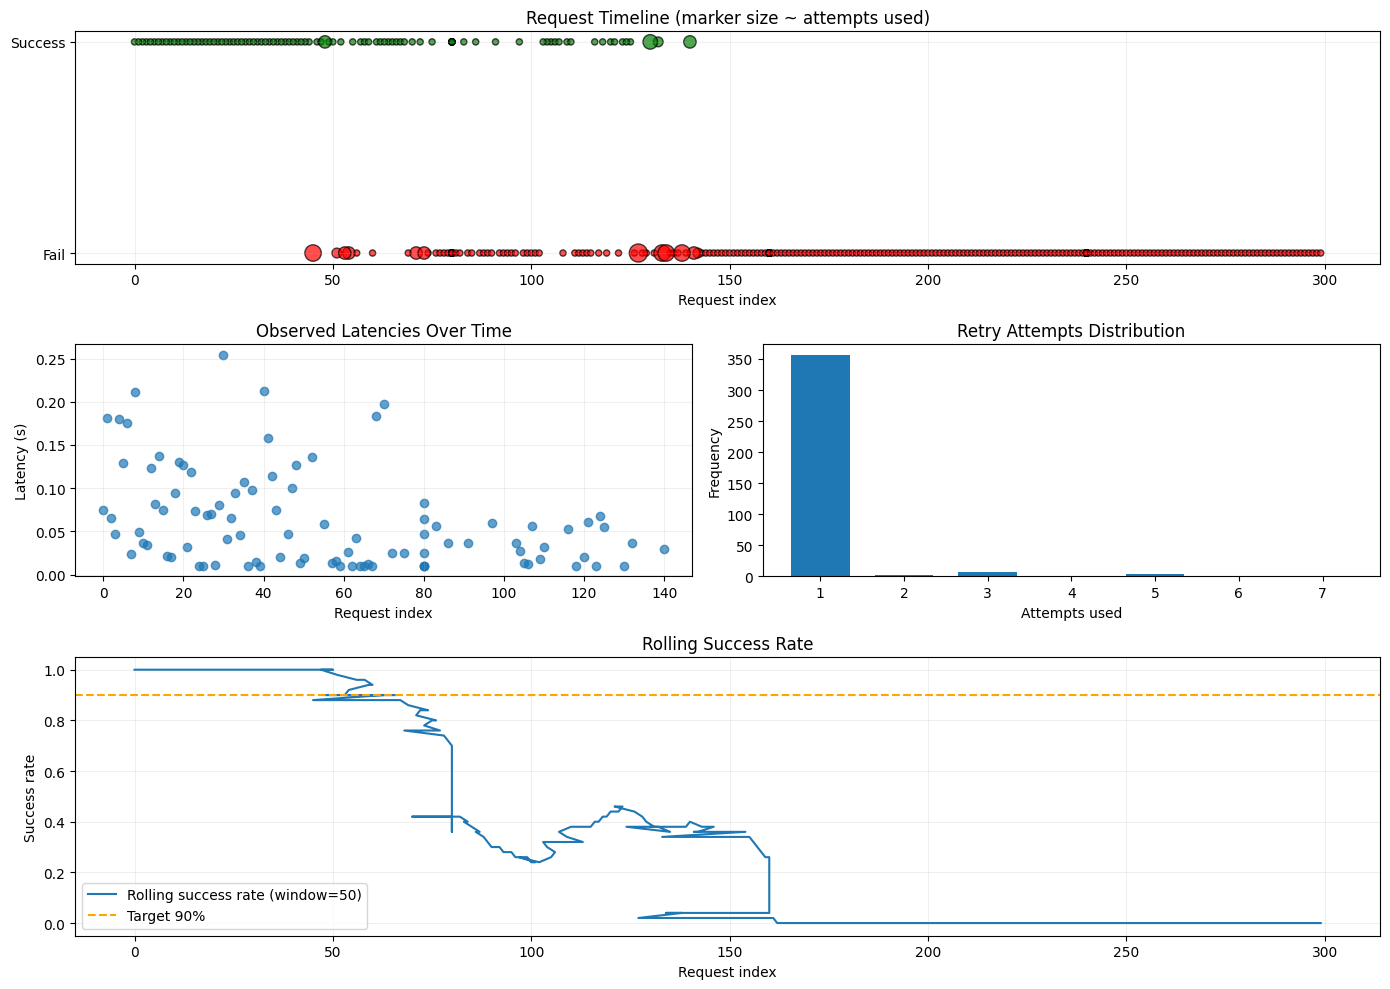

In [5]:
"""
Realistic Backend Availability Simulation
- multiple services (auth/payments/catalog) with distinct failure/latency profiles
- asyncio concurrency to simulate parallel clients
- token bucket rate limiter (per-service) to simulate rate limits (429)
- circuit breaker (open/half-open/closed) per service
- retries with exponential backoff + full jitter
- distinguishes transient vs permanent errors
- collects metrics: success/fail, attempts, latencies, error types
- multi-panel plotting: timeline (status + attempts), latency series, retry histogram,
  and rolling success rate
"""

import asyncio
import random
import time
from collections import defaultdict, deque, Counter
import math
import statistics
import logging

import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Logging & constants
# -----------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

TOTAL_REQUESTS = 300            # total simulated client requests
CONCURRENCY = 30                # concurrent "clients"
ROLLING_WINDOW = 50             # for moving success rate plot

# -----------------------
# Service profiles
# -----------------------
# Each service has:
#  - base_failure: probability of transient failure (HTTP 5xx)
#  - permanent_failure: probability of permanent failure (client error, e.g., 4xx that shouldn't be retried)
#  - rate_limit_rate: token refill rate (tokens/sec)
#  - burst_size: token bucket capacity
#  - latency_dist: function returning latency in seconds (can be heavy-tailed)
services = {
    "auth": {
        "base_failure": 0.03,   # 3% transient
        "permanent_failure": 0.005,
        "rate_limit_rate": 8,
        "burst_size": 20,
        "latency_dist": lambda: max(0.02, random.gauss(0.08, 0.05) + np.random.exponential(0.02)),
    },
    "payments": {
        "base_failure": 0.08,   # more flaky
        "permanent_failure": 0.01,
        "rate_limit_rate": 4,
        "burst_size": 8,
        "latency_dist": lambda: max(0.05, random.gammavariate(2.0, 0.05) + np.random.exponential(0.05)),
    },
    "catalog": {
        "base_failure": 0.02,
        "permanent_failure": 0.002,
        "rate_limit_rate": 15,
        "burst_size": 30,
        "latency_dist": lambda: max(0.01, random.gauss(0.03, 0.02)),
    },
}

# -----------------------
# Token Bucket Rate Limiter (per service)
# -----------------------
class TokenBucket:
    def __init__(self, rate, capacity):
        self.rate = rate
        self.capacity = capacity
        self.tokens = capacity
        self.last = time.monotonic()
        self.lock = asyncio.Lock()

    async def consume(self, tokens=1):
        async with self.lock:
            now = time.monotonic()
            elapsed = now - self.last
            self.tokens = min(self.capacity, self.tokens + elapsed * self.rate)
            self.last = now
            if self.tokens >= tokens:
                self.tokens -= tokens
                return True
            return False

# -----------------------
# Simple circuit breaker
# -----------------------
class CircuitBreaker:
    def __init__(self, fail_threshold=0.25, min_calls=10, cooldown=5.0):
        self.fail_threshold = fail_threshold
        self.min_calls = min_calls
        self.cooldown = cooldown
        self.calls = deque(maxlen=1000)
        self.state = "CLOSED"
        self.opened_at = None

    def record(self, success: bool):
        self.calls.append(success)
        if self.state == "OPEN":
            # check cooldown
            if time.monotonic() - (self.opened_at or 0) >= self.cooldown:
                self.state = "HALF_OPEN"
        elif self.state in ("CLOSED", "HALF_OPEN"):
            self._maybe_open()

    def _maybe_open(self):
        if len(self.calls) >= self.min_calls:
            fails = sum(1 for s in self.calls if not s)
            ratio = fails / len(self.calls)
            if ratio >= self.fail_threshold:
                self.state = "OPEN"
                self.opened_at = time.monotonic()
                logging.warning(f"Circuit breaker OPEN (fail ratio={ratio:.2f})")

    def allow_request(self):
        if self.state == "OPEN":
            # immediate reject
            return False
        return True

    def on_success(self):
        if self.state == "HALF_OPEN":
            # heal
            self.state = "CLOSED"
            self.calls.clear()

# -----------------------
# Simulated backend call
# -----------------------
class ServiceBackend:
    def __init__(self, name, profile):
        self.name = name
        self.profile = profile
        self.tokens = TokenBucket(profile["rate_limit_rate"], profile["burst_size"])
        self.cbreaker = CircuitBreaker(fail_threshold=0.3, min_calls=12, cooldown=8.0)

    async def call(self):
        # If circuit is open, reject immediately as a permanent failure
        if not self.cbreaker.allow_request():
            raise PermanentError("circuit_open")

        # Rate limiter
        allowed = await self.tokens.consume()
        if not allowed:
            # simulate 429 Too Many Requests
            raise RateLimitError("rate_limited")

        # latency = draw from distribution; simulate
        latency = self.profile["latency_dist"]()
        await asyncio.sleep(latency)

        # permanent failures (client-side issues)
        if random.random() < self.profile["permanent_failure"]:
            raise PermanentError("client_error")

        # transient failures (retryable)
        if random.random() < self.profile["base_failure"]:
            raise TransientError("server_error")

        # success
        return {"service": self.name, "data": {"errors": random.randint(0, 20)}}, latency

# -----------------------
# Custom Exceptions
# -----------------------
class TransientError(Exception):
    pass

class PermanentError(Exception):
    pass

class RateLimitError(TransientError):
    pass

# -----------------------
# Retry policy: full jitter exponential backoff
# -----------------------
async def retry_call(backend: ServiceBackend, max_attempts=5, base_delay=0.05, max_delay=2.0):
    attempt = 0
    while attempt < max_attempts:
        attempt += 1
        try:
            result, latency = await backend.call()
            backend.cbreaker.record(True)
            backend.cbreaker.on_success()
            return {"status": "success", "attempts": attempt, "latency": latency}
        except PermanentError as e:
            backend.cbreaker.record(False)
            # do not retry permanent errors
            return {"status": "permanent_fail", "attempts": attempt, "error": str(e)}
        except TransientError as e:
            backend.cbreaker.record(False)
            # If it's a rate limit we might want to back off harder
            # compute exponential backoff with full jitter
            exp = min(max_delay, base_delay * (2 ** (attempt - 1)))
            jitter = random.uniform(0, exp)
            await asyncio.sleep(jitter)
            # continue retrying until attempts exhausted
        except Exception as e:
            # unknown errors treated transiently
            backend.cbreaker.record(False)
            exp = min(max_delay, base_delay * (2 ** (attempt - 1)))
            jitter = random.uniform(0, exp)
            await asyncio.sleep(jitter)
    # all attempts exhausted
    return {"status": "exhausted", "attempts": max_attempts}

# -----------------------
# Simulation driver
# -----------------------
async def run_simulation():
    # create backends
    backends = {name: ServiceBackend(name, profile) for name, profile in services.items()}

    # metrics collectors
    timeline = []       # per-request entries (index, service, status, attempts, latency_or_none)
    attempts_hist = []
    latencies = []
    error_counter = Counter()
    success_queue = deque(maxlen=ROLLING_WINDOW)

    sem = asyncio.Semaphore(CONCURRENCY)
    request_idx = 0

    async def client_task(idx):
        nonlocal request_idx
        async with sem:
            # simulate client picking a service randomly, but with weights to mimic realistic traffic
            service_choice = random.choices(list(backends.keys()), weights=[0.45, 0.15, 0.40])[0]
            backend = backends[service_choice]
            res = await retry_call(backend, max_attempts=6, base_delay=0.04)
            status = res["status"]
            attempts = res.get("attempts", 0)
            latency = res.get("latency", None)

            # fill metrics
            timeline.append((idx, service_choice, status, attempts, latency))
            attempts_hist.append(attempts)
            if latency is not None:
                latencies.append((idx, latency))
            if status == "success":
                success_queue.append(1)
            else:
                success_queue.append(0)
                error_counter[status] += 1

    # spawn tasks with some burstiness: occasional spikes
    tasks = []
    for i in range(TOTAL_REQUESTS):
        # introduce spikes every ~80 requests
        if i % 80 == 0 and i > 0:
            # small burst: spin up many requests quickly
            for _ in range(25):
                tasks.append(asyncio.create_task(client_task(i)))
            # then a small cooldown
            await asyncio.sleep(0.3)
        else:
            tasks.append(asyncio.create_task(client_task(i)))
            # inter-arrival time to simulate normal traffic (poisson-like)
            await asyncio.sleep(random.expovariate(1/0.02))  # avg 0.02s between submissions

    await asyncio.gather(*tasks)

    # compute metrics
    total = len(timeline)
    success = sum(1 for t in timeline if t[2] == "success")
    fail_total = total - success
    avg_attempts = statistics.mean(attempts_hist) if attempts_hist else 0
    avg_latency = statistics.mean([l for _, l in latencies]) if latencies else None

    print("=== Simulation Summary ===")
    print(f"Total requests: {total}")
    print(f"Successful: {success} ({success/total*100:.2f}%)")
    print(f"Failed: {fail_total} ({fail_total/total*100:.2f}%)")
    print(f"Average attempts per request: {avg_attempts:.2f}")
    if avg_latency is not None:
        print(f"Average latency (observed successes): {avg_latency:.3f}s")
    print("Error breakdown:", dict(error_counter))

    # -----------------------
    # Visualization
    # -----------------------
    # Convert timeline to arrays for plotting
    idxs = [t[0] for t in timeline]
    status_vals = [1 if t[2]=="success" else 0 for t in timeline]
    attempts_vals = [t[3] for t in timeline]
    lat_idx = [li for li, _ in latencies]
    lat_vals = [l for _, l in latencies]

    # rolling success rate over requests
    rolling = []
    successes = 0
    dq = deque()
    for s in status_vals:
        dq.append(s)
        if len(dq) > ROLLING_WINDOW:
            dq.popleft()
        rolling.append(sum(dq)/len(dq))

    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.2])

    # timeline: success/fail and attempts indicated by marker size
    ax1 = fig.add_subplot(gs[0, :])
    colors = ["green" if s==1 else "red" for s in status_vals]
    sizes = [20 + (a-1)*30 for a in attempts_vals]
    ax1.scatter(idxs, status_vals, c=colors, s=sizes, alpha=0.7, edgecolor='k')
    ax1.set_yticks([0,1]); ax1.set_yticklabels(["Fail","Success"])
    ax1.set_title("Request Timeline (marker size ~ attempts used)")
    ax1.set_xlabel("Request index")
    ax1.grid(alpha=0.2)

    # latency series
    ax2 = fig.add_subplot(gs[1, 0])
    if lat_idx:
        ax2.scatter(lat_idx, lat_vals, alpha=0.7)
        ax2.set_ylabel("Latency (s)")
        ax2.set_title("Observed Latencies Over Time")
        ax2.set_xlabel("Request index")
        ax2.grid(alpha=0.2)
    else:
        ax2.text(0.5, 0.5, "No latency data", ha="center")
        ax2.set_title("Observed Latencies Over Time")

    # retry histogram
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(attempts_hist, bins=range(1, 9), align='left', rwidth=0.7)
    ax3.set_title("Retry Attempts Distribution")
    ax3.set_xlabel("Attempts used")
    ax3.set_ylabel("Frequency")

    # rolling success rate
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(idxs, rolling, label=f"Rolling success rate (window={ROLLING_WINDOW})")
    ax4.axhline(y=0.9, color='orange', linestyle='--', label='Target 90%')
    ax4.set_ylim(-0.05, 1.05)
    ax4.set_title("Rolling Success Rate")
    ax4.set_xlabel("Request index")
    ax4.set_ylabel("Success rate")
    ax4.legend()
    ax4.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

# -----------------------
# Entrypoint
# -----------------------
# In a Jupyter cell (no __main__ guard needed)
await run_simulation()

